In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from tqdm.notebook import tqdm_notebook
#from kneed import KneeLocator
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
#from scipy.optimize import curve_fit
from tqdm import tqdm

# Read data

In [2]:
df = pd.read_csv('./Beehive_10.csv')
#df.loc[df['ra'] > 300, 'ra'] -= 360 #SOLO PARA BLANCO 1
#c_pm = (df['pmra'] > -30) & (df['pmra'] < 0) & (df['pmdec'] > 0) & (df['pmdec'] < 30)
#df = df[c_pm]
df = df.fillna(0)
df['parallax'] = df['parallax'] / 1000
df['parallax_error'] = df['parallax_error'] / 1000
print(df.shape)
df

(80703, 23)


,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,...,rp,rp_error,bp,bp_error,visibility_periods_used,astrometric_excess_noise,ruwe,phot_bp_rp_excess_factor,dr2_radial_velocity,dr2_radial_velocity_error
0,609981705034687232,131.280212,0.031714,15.474269,0.016747,0.003981,0.000037,-3.215887,0.040744,-36.037747,...,14.470887,12.751572,16.444292,9.401448,19,0.082259,1.055217,1.339753,0.000000,0.00000
1,609981735098860928,131.297966,0.106796,15.487158,0.054884,0.002844,0.000120,6.036407,0.138585,-13.361651,...,16.779990,7.189133,19.021648,14.447100,19,0.117308,1.034201,1.384453,0.000000,0.00000
2,606816000603725568,138.678761,0.081287,15.229259,0.059422,0.002159,0.000096,-10.967262,0.109706,-8.054500,...,16.524103,7.640090,18.872038,5.606391,19,0.186261,1.062065,1.393438,0.000000,0.00000
3,606816722158209024,138.920231,0.039930,15.162979,0.028212,0.003855,0.000047,-35.318601,0.052235,3.958735,...,15.222104,12.799838,17.396177,8.644682,17,0.000000,0.967320,1.364603,0.000000,0.00000
4,606816790877688832,138.944195,0.085132,15.173279,0.061080,0.002601,0.000097,-16.787298,0.111604,3.090487,...,16.406555,7.400974,18.863182,8.051564,17,0.000000,0.989196,1.408178,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80698,603480602017278336,129.382189,0.012376,14.382331,0.007760,0.002396,0.000015,-5.315868,0.015258,-17.965114,...,12.121287,42.795963,12.923973,54.159880,17,0.033034,0.926027,1.195553,59.367165,3.08886
80699,603480670736754944,129.369064,0.184921,14.392128,0.116363,0.002958,0.000210,-4.693002,0.213921,-26.406189,...,17.465170,13.027057,20.102995,9.006048,17,0.468608,0.985029,1.466425,0.000000,0.00000
80700,603480803880119040,129.415450,0.172693,14.386731,0.109498,0.003144,0.000207,0.426192,0.196650,-34.930282,...,17.308805,13.242037,19.709011,15.153356,17,0.000000,1.014161,1.420381,0.000000,0.00000
80701,603481903391753728,129.376046,0.213929,14.426241,0.140503,0.003501,0.000248,-4.209058,0.252801,-21.640871,...,17.742683,6.234222,20.702843,7.023109,17,0.000000,0.993190,1.438219,0.000000,0.00000


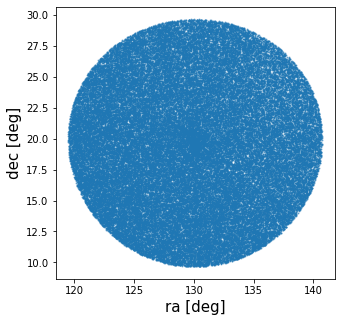

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(df['ra'], df['dec'], marker='o' , s=1, alpha = 0.5)
plt.xlabel("ra [deg]",  fontsize = 15)
plt.ylabel("dec [deg]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
plt.show()

#plt.figure(figsize=(5,5))
#plt.scatter(df['pmra'], df['pmdec'], marker='o' , s=5, alpha = 0.5)
#plt.xlabel("pmra [mas $yr^{-1}$]",  fontsize = 15)
#plt.ylabel("pmdec [mas $yr^{-1}$]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
#plt.show()

# Generate data

In [4]:
def pdf(x, mu, std):
    return 1/np.sqrt(2*np.pi*std**2) * np.exp(-(x-mu)**2 / (2*std**2))

def metropolis_hastings(x, mu, std, delta=0.1):
    x_new = x + (np.random.random()-0.5)*2.0*delta
    gamma = min(1, pdf(x_new, mu, std)/pdf(x, mu, std))
    alpha = np.random.random()
    if alpha < gamma:
        x = x_new
    return x

  0%|                                                    | 0/30 [00:00<?, ?it/s]

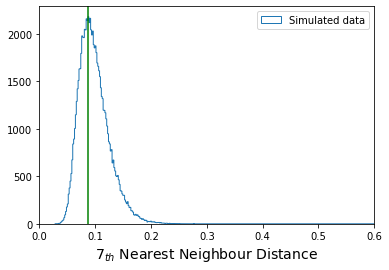

  3%|█▍                                          | 1/30 [00:04<02:11,  4.53s/it]

0.08688074128377986


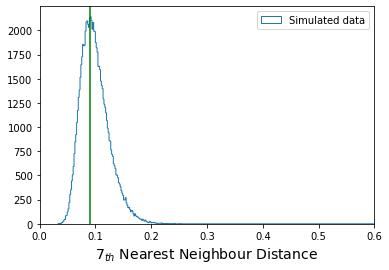

  7%|██▉                                         | 2/30 [00:09<02:13,  4.76s/it]

0.09082298563880684


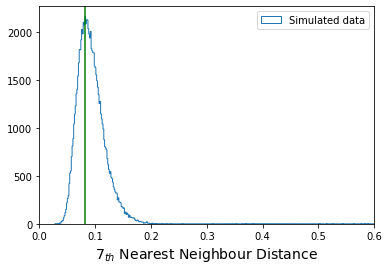

 10%|████▍                                       | 3/30 [00:14<02:07,  4.73s/it]

0.08121422865792435


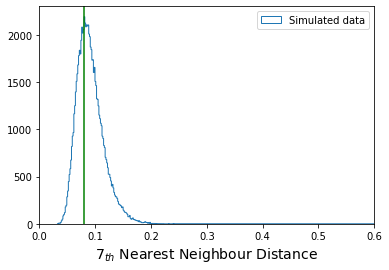

 13%|█████▊                                      | 4/30 [00:19<02:05,  4.83s/it]

0.0798727086858591


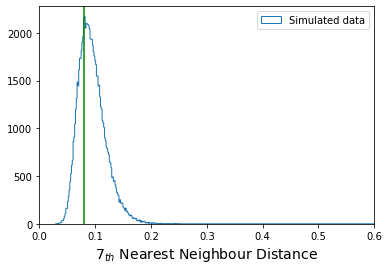

 17%|███████▎                                    | 5/30 [00:23<01:58,  4.75s/it]

0.08044556842296512


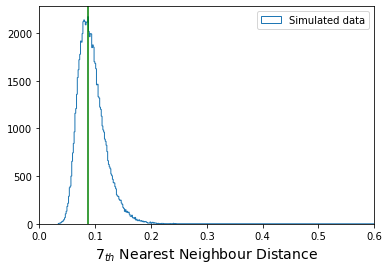

 20%|████████▊                                   | 6/30 [00:28<01:54,  4.77s/it]

0.08645427846345473


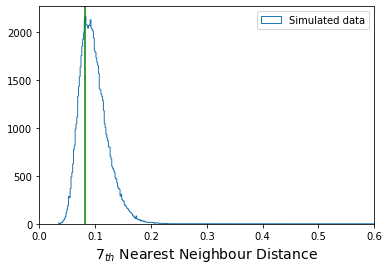

 23%|██████████▎                                 | 7/30 [00:33<01:48,  4.72s/it]

0.08186652876191113


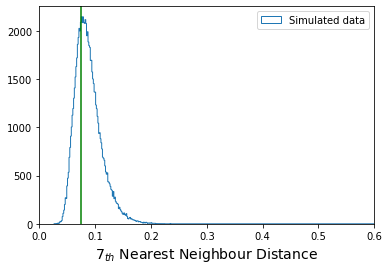

 27%|███████████▋                                | 8/30 [00:38<01:45,  4.78s/it]

0.07478918178217472


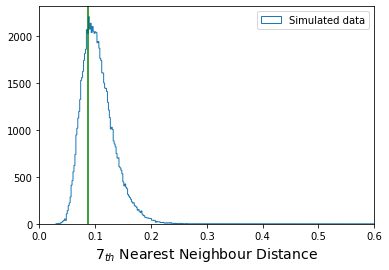

 30%|█████████████▏                              | 9/30 [00:42<01:38,  4.68s/it]

0.08758559137097706


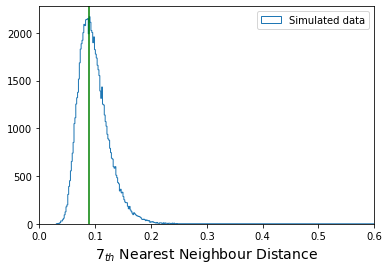

 33%|██████████████▎                            | 10/30 [00:47<01:32,  4.64s/it]

0.08904504170255652


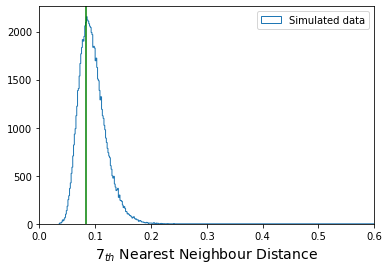

 37%|███████████████▊                           | 11/30 [00:52<01:30,  4.75s/it]

0.08402990473029143


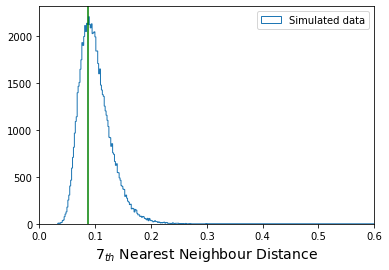

 40%|█████████████████▏                         | 12/30 [00:56<01:23,  4.63s/it]

0.087671118516315


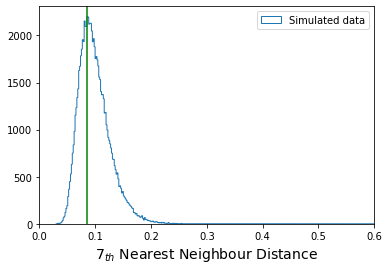

 43%|██████████████████▋                        | 13/30 [01:00<01:17,  4.55s/it]

0.08502933525342682


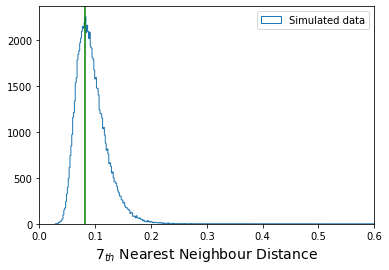

 47%|████████████████████                       | 14/30 [01:05<01:12,  4.52s/it]

0.08160089204481304


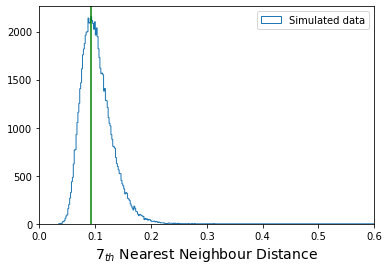

 50%|█████████████████████▌                     | 15/30 [01:09<01:08,  4.55s/it]

0.09189978321970182


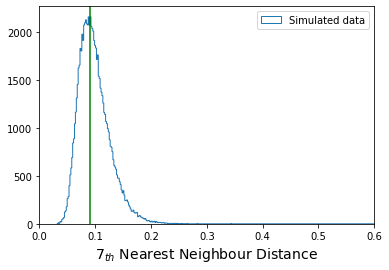

 53%|██████████████████████▉                    | 16/30 [01:14<01:02,  4.49s/it]

0.09067754135231182


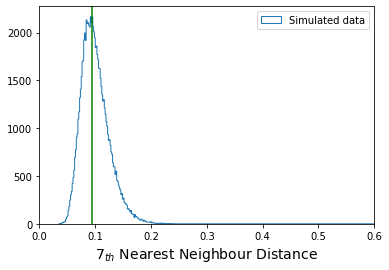

 57%|████████████████████████▎                  | 17/30 [01:19<01:00,  4.62s/it]

0.09407876302907012


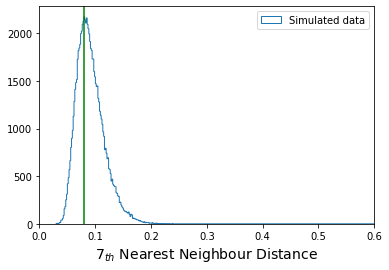

 60%|█████████████████████████▊                 | 18/30 [01:24<00:56,  4.75s/it]

0.07962217761001943


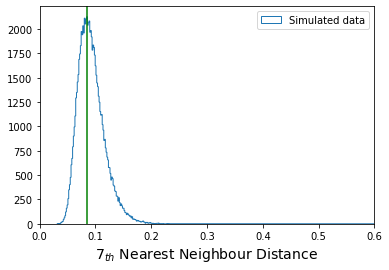

 63%|███████████████████████████▏               | 19/30 [01:29<00:55,  5.03s/it]

0.08431045364335142


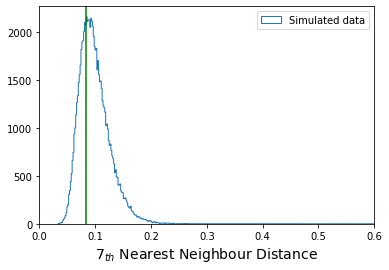

 67%|████████████████████████████▋              | 20/30 [01:34<00:48,  4.84s/it]

0.08387723899049102


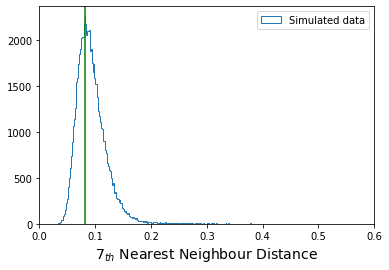

 70%|██████████████████████████████             | 21/30 [01:39<00:43,  4.82s/it]

0.08098903345644777


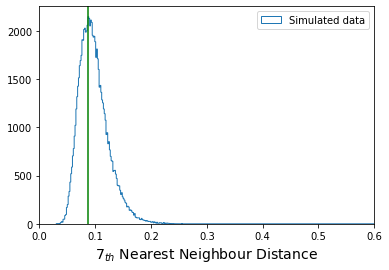

 73%|███████████████████████████████▌           | 22/30 [01:43<00:37,  4.74s/it]

0.08688304618811166


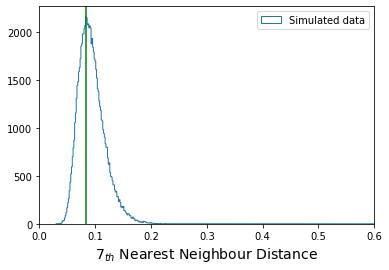

 77%|████████████████████████████████▉          | 23/30 [01:48<00:34,  4.89s/it]

0.08267618522302582


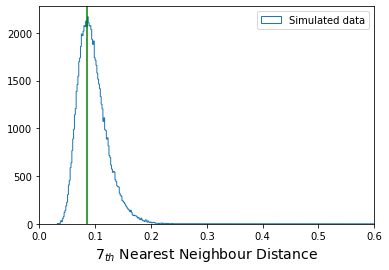

 80%|██████████████████████████████████▍        | 24/30 [01:53<00:28,  4.77s/it]

0.0858972068038795


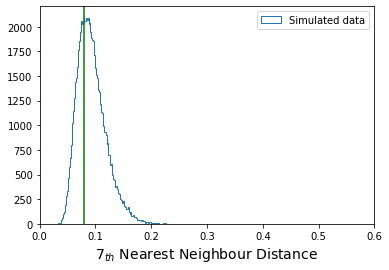

 83%|███████████████████████████████████▊       | 25/30 [01:57<00:23,  4.67s/it]

0.07878772199383992


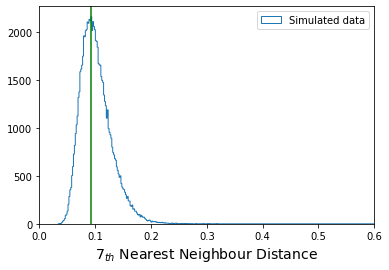

 87%|█████████████████████████████████████▎     | 26/30 [02:02<00:18,  4.57s/it]

0.0920543677506996


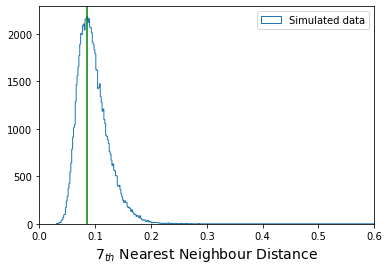

 90%|██████████████████████████████████████▋    | 27/30 [02:06<00:13,  4.50s/it]

0.08501026559913893


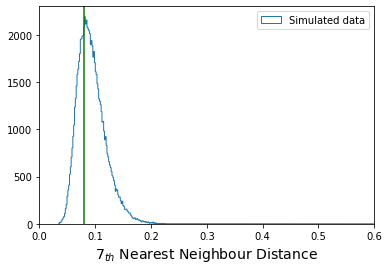

 93%|████████████████████████████████████████▏  | 28/30 [02:11<00:09,  4.52s/it]

0.0807143314381617


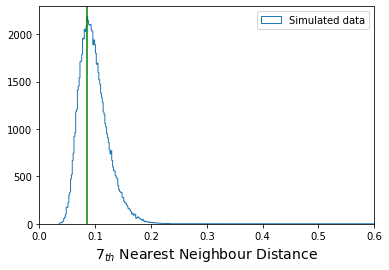

 97%|█████████████████████████████████████████▌ | 29/30 [02:15<00:04,  4.51s/it]

0.08493566993194254


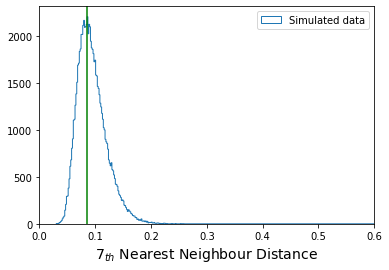

100%|███████████████████████████████████████████| 30/30 [02:19<00:00,  4.66s/it]

0.08528474161628008


In [5]:
eps_simulated = []
for k in tqdm(range(0,30)):
    names = ['ra','dec','pmra','pmdec','parallax']
    simulated_data = []
    for i in names:
        n_iteraciones = len(df[i])
        random_data = np.ones(n_iteraciones)
        mu, std = np.mean(df[i]), np.std(df[i])
        for j in range(1, n_iteraciones):
            random_data[j] = metropolis_hastings(random_data[j-1], mu, std, delta=1)
        simulated_data.append(random_data)
        random_teorico = np.linspace(min(random_data), max(random_data), len(df[i]))
        p_random_teorico = pdf(random_teorico, mu, std)

        #plt.hist(random_data, bins=50, density=True,alpha=0.5, label='Simulated data',histtype=u'step')
        #plt.plot(random_teorico, p_random_teorico, label='PDF')
        #plt.xlabel(i, fontsize=14)
        #plt.ylabel('Frequency',fontsize=14)
        #if i=='parallax':
        #    plt.xlim(0,5)
        #plt.legend()
        #plt.show()

    df_simulated = pd.DataFrame(np.array(simulated_data).transpose(), columns=['ra', 'dec','pmra','pmdec','parallax'])
    df_simulated = df_simulated.astype('float32')
    df_simulated = StandardScaler().fit(df_simulated).transform(df_simulated)

    neigh = NearestNeighbors(n_neighbors = 7, algorithm = 'kd_tree', n_jobs=8).fit(df_simulated)
    distances_simulated, indices = neigh.kneighbors(df_simulated)
    distances_simulated = np.sort(np.mean(distances_simulated, axis = 1))
    hist, bin_edges = np.histogram(distances_simulated, bins='auto',range=(min(distances_simulated),max(distances_simulated)))
    i = hist.argmax()

    #eps_simulated.append(min(distances_simulated))
    eps_simulated.append(bin_edges[i])
    
    #plt.hist(distances, bins='auto', label='Region of Blanco 1',histtype=u'step')
    plt.hist(distances_simulated, bins='auto', label='Simulated data',histtype=u'step')
    plt.xlabel(r'$7_{th}$ Nearest Neighbour Distance ', fontsize=14)
    plt.xlim(0,0.6)
    plt.axvline(eps_simulated[k],c='green')
    plt.legend()
    plt.show()
    print(eps_simulated[k])

In [6]:
np.savetxt('./beehive_eps_simulated.txt', eps_simulated, delimiter=',')
eps_simulated

[0.08688074128377986,
 0.09082298563880684,
 0.08121422865792435,
 0.0798727086858591,
 0.08044556842296512,
 0.08645427846345473,
 0.08186652876191113,
 0.07478918178217472,
 0.08758559137097706,
 0.08904504170255652,
 0.08402990473029143,
 0.087671118516315,
 0.08502933525342682,
 0.08160089204481304,
 0.09189978321970182,
 0.09067754135231182,
 0.09407876302907012,
 0.07962217761001943,
 0.08431045364335142,
 0.08387723899049102,
 0.08098903345644777,
 0.08688304618811166,
 0.08267618522302582,
 0.0858972068038795,
 0.07878772199383992,
 0.0920543677506996,
 0.08501026559913893,
 0.0807143314381617,
 0.08493566993194254,
 0.08528474161628008]

# K Nearest Neighbour Distance

In [7]:
data = df[['ra','dec','pmra','pmdec','parallax']]
data = data.astype('float32')
data = StandardScaler().fit(data).transform(data)

neigh = NearestNeighbors(n_neighbors=7, algorithm = 'ball_tree',n_jobs=4).fit(data)
distances, indices = neigh.kneighbors(data)
distances = np.sort(np.mean(distances, axis = 1))

eps_simulated = np.loadtxt('./beehive_eps_simulated.txt')

hist, bin_edges = np.histogram(distances, bins='auto',range=(min(distances),max(distances)))
i = hist.argmax()
max_value = bin_edges[i]
average_eps_simulated = np.average(eps_simulated)
average_distance = np.average(distances)
print(average_eps_simulated)

0.0848335544387243


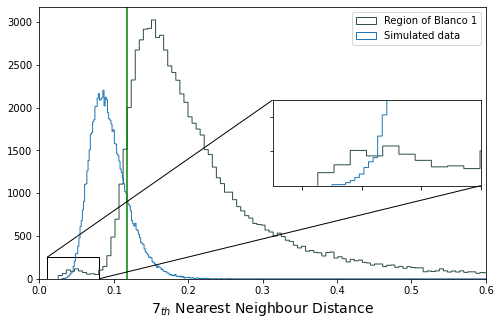

In [8]:
fig, ax = plt.subplots(figsize=[8, 5]) # create a new figure with a default 111 subplot
#plt.subplots_adjust(bottom = 0.15)
ax.hist(distances, bins='auto', label='Region of Blanco 1',histtype=u'step',color='darkslategray')
ax.hist(distances_simulated, bins='auto', label='Simulated data',histtype=u'step')
plt.xlabel(r'$7_{th}$ Nearest Neighbour Distance ', fontsize=14)
plt.xlim(0,0.6)
#plt.axvline(average_eps_simulated, label=r'Simulated $\epsilon=$ {:.09}'.format(0.11623179806790337),c='cyan')
#plt.axvline(max_value, label=r'7NND $\epsilon=$ {:.09}'.format(max_value),c='green')
plt.axvline((max_value+average_eps_simulated)/2,c='green')
plt.legend()

axins = zoomed_inset_axes(ax, 4, loc = 7) # zoom-factor: 2.5, location: upper-left
axins.hist(distances, bins='auto', label='Region of Blanco 1',histtype=u'step',color='darkslategray')#x1, x2, y1, y2 = 14, 24, -3, 7 # specify the limits
axins.hist(distances_simulated, bins='auto', label='Simulated data',histtype=u'step')
x1, x2, y1, y2 = 0.01, 0.08, 0.010, 250
axins.set_xlim(x1, x2) 
axins.set_ylim(y1, y2) 
plt.yticks(visible = False)
plt.xticks(visible = False)
mark_inset(ax, axins, loc1 = 2, loc2 = 4, fc = "white", ec = "black", linewidth = 1)
#axins.grid()
axins.spines['bottom'].set_color('black')
axins.spines['top'].set_color('black')
axins.spines['right'].set_color('black')
axins.spines['left'].set_color('black')
#plt.savefig('./knnd.png',bbox_inches='tight')

In [9]:
print('max_value:',max_value)
print('Average eps simulated:',average_eps_simulated)
eps = (average_eps_simulated + max_value)/2
print('eps:',eps)

max_value: 0.15058855133325758
Average eps simulated: 0.0848335544387243
eps: 0.11771105288599093


In [10]:
db = DBSCAN(eps = eps, min_samples = 8, n_jobs = 8, algorithm='ball_tree').fit(data)
labels = db.labels_ 
df['Clusters'] = labels
for i in list(set(labels)):
    print('{} {}'.format(i,len(df[(df['Clusters'] == i)])))

0 810
1 9
2 8
3 8
4 8
5 10
6 9
7 8
8 8
-1 79825


In [11]:
#for i in list(set(labels)):
#    if len(df[(df['Clusters'] == i)]) > 50:
#        print('{} {}'.format(i,len(df[(df['Clusters'] == i)])))

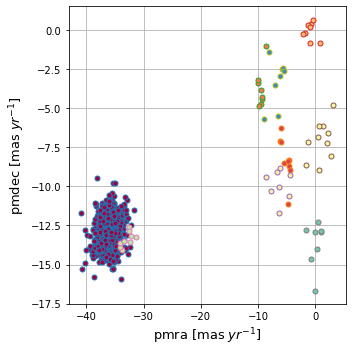

In [13]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(5,5))
for i, j in zip(list(unique_labels), colors):
    if not i == -1:# or i == 0:
        plt.plot(df['pmra'][(df['Clusters'] == i)], df['pmdec'][(df['Clusters'] == i)], 
         markerfacecolor = tuple(j),marker = 'o', linestyle='None',markersize = 5, alpha = 1)
#else:
        #plt.plot(df['pmra'][(df['Clusters'] == i)], df['pmdec'][(df['Clusters'] == i)], 
        # color = 'black', marker='o' ,linestyle = 'None', markersize = 5, alpha = 1)
        #plt.scatter(0,0,marker='.')
plt.xlabel("pmra [mas $yr^{-1}$]",  fontsize = 13)
plt.ylabel("pmdec [mas $yr^{-1}$]",  fontsize = 13)#,rotation=0)
#plt.xlim(-40,20)
#plt.ylim(-20,40)
plt.tight_layout()
plt.grid()
plt.savefig('./dbscan_images/beehive_vpd_dbscan_complete.jpg',bbos_inches='tight')
plt.show() #should be on pmra(-26,-16) and pmdec(10,20)

<Figure size 360x360 with 0 Axes>

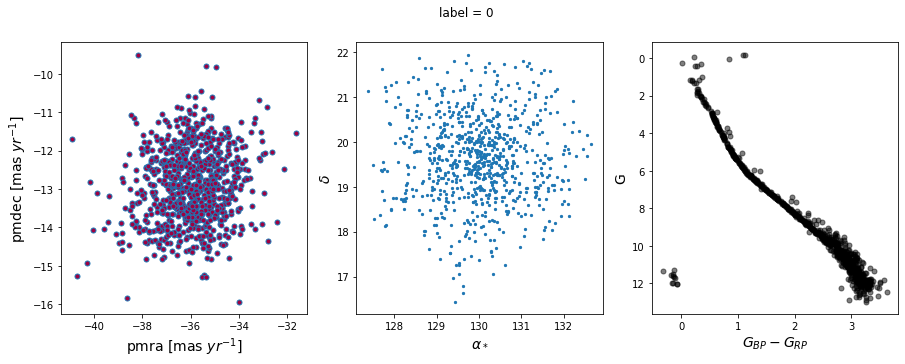

In [14]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(5,5))
for i, j in zip(list(unique_labels), colors):
    if not i == -1 and len(df[(df['Clusters'] == i)]) > 50:# or i == 0:
        
        plt.figure(figsize=(15,5))
        plt.suptitle('label = {}'.format(i))
        plt.subplot(1,3,1)
        plt.plot(df['pmra'][(df['Clusters'] == i)], df['pmdec'][(df['Clusters'] == i)], 
         markerfacecolor = tuple(j),marker = 'o', linestyle='None',markersize = 5, alpha = 1)
        plt.xlabel("pmra [mas $yr^{-1}$]",  fontsize = 14)
        plt.ylabel("pmdec [mas $yr^{-1}$]",  fontsize = 14)#,rotation=0)
        
        plt.subplot(1,3,2)
        plt.scatter(df['ra'][(df['Clusters'] == i)], df['dec'][(df['Clusters'] == i)], marker='o' , s=5, alpha = 1)
        plt.xlabel(r'$\alpha_*$',fontsize = 14)
        plt.ylabel(r'$\delta$',fontsize = 14)
        
        g_mag = df['g'][(df['Clusters'] == i)] + 5 - 5*np.log10(1/df['parallax'][(df['Clusters'] == i)])
        color = df['bp'][(df['Clusters'] == i)] - df['rp'][(df['Clusters'] == i)]
        plt.subplot(1,3,3)
        plt.plot(color, g_mag,color='black',marker='o',linestyle='None',markersize=5,alpha=0.5)
        plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 14)
        plt.ylabel("G", fontsize = 14)
        plt.gca().invert_yaxis()

plt.show() #should be on pmra(-26,-16) and pmdec(10,20)

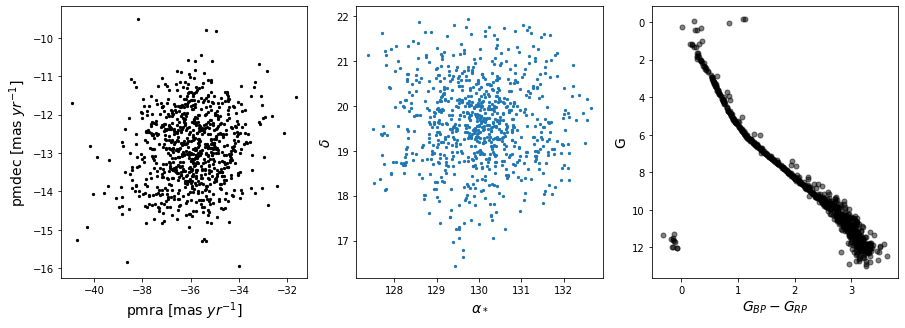

In [15]:
n = 0
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(df['pmra'][(df['Clusters'] == n)], df['pmdec'][(df['Clusters'] == n)], 
             color = 'black', marker='o' , s = 5, alpha = 1)
plt.xlabel("pmra [mas $yr^{-1}$]", fontsize = 14)
plt.ylabel("pmdec [mas $yr^{-1}$]", fontsize = 14)#,rotation=0)
#plt.xlim(-40,20)
#plt.ylim(-20,40)

plt.subplot(1,3,2)
plt.scatter(df['ra'][(df['Clusters'] == n)], df['dec'][(df['Clusters'] == n)], marker='o' , s=5, alpha = 1)
plt.xlabel(r'$\alpha_*$',fontsize = 14)
plt.ylabel(r'$\delta$',fontsize = 14)

g_mag = df['g'][(df['Clusters'] == n)] + 5 - 5*np.log10(1/df['parallax'][(df['Clusters'] == n)])
color = df['bp'][(df['Clusters'] == n)] - df['rp'][(df['Clusters'] == n)]
plt.subplot(1,3,3)
plt.plot(color, g_mag,color='black',marker='o',linestyle='None',markersize=5,alpha=0.5)
plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 14)
plt.ylabel("G", fontsize = 14)
plt.gca().invert_yaxis()
#plt.savefig('./vpd.jpg')
plt.show()

In [16]:
df_test = df[(df['Clusters'] == n)]
df_test.to_csv('./beehive_dbscan.csv')

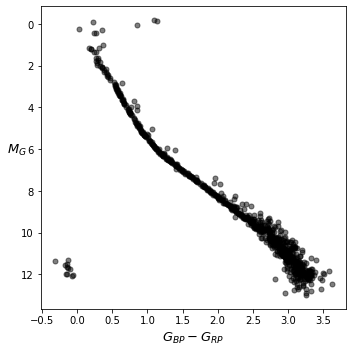

In [17]:
plt.figure(figsize=(5,5))
plt.plot(color, g_mag,color='black',marker='o',linestyle='None',markersize=5,alpha=0.5)
plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 13)
plt.ylabel(r"$M_G$", fontsize = 13, rotation=0)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('./dbscan_images/beehive_cmd_dbscan.jpg',bbos_inches='tight')
plt.show()

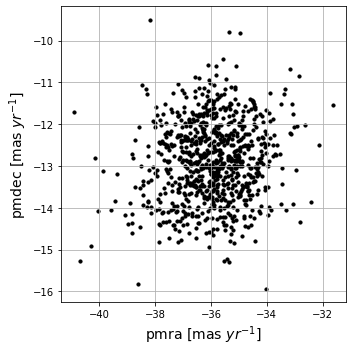

In [18]:
plt.figure(figsize=(5,5))
plt.grid()
plt.scatter(df['pmra'][(df['Clusters']==n)],df['pmdec'][(df['Clusters']==n)],color='black',marker='o',s=10,alpha=1)
plt.xlabel("pmra [mas $yr^{-1}$]", fontsize = 14)
plt.ylabel("pmdec [mas $yr^{-1}$]", fontsize = 14)#,rotation=0)
#plt.xlim(-40,20)
#plt.ylim(-20,40)
plt.tight_layout()
plt.savefig('./dbscan_images/beehive_vpd_dbscan.jpg',bbos_inches='tight')
plt.show()